In [1]:
import marimo as mo

# Revisão do artigo “Model-independent quantum phases classifier”

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["NewComputerModernMath", "Times New Roman"],
        "font.sans-serif": ["NewComputerModernSans", "San Francisco Display"],
        "axes.labelsize": 14,
        "font.size": 14,
        "legend.fontsize": 13,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.titlesize": 22,
        "svg.fonttype": "none",
    }
)


In [63]:
PHASES = ("Haldane", "Trimer", "Ferro", "Dimer", "LD", "XY1", "Neel", "XY2")
COLORS = (
    "#00A087",  # Teal Green
    "#3B75AF",  # Royal Blue
    "#F37735",  # Vibrant Orange
    "#FFC425",  # Gold
    "#E83E8C",  # Magenta
    "#7B52A1",  # Royal Purple
    "#0B2545",  # Oxford Blue
    "#999999",  # Medium Gray
)

H_KEYS = ("H1", "H2", "H3")

PHASE_COLORS = dict(zip(PHASES, COLORS))

phase_trans_H1 = pd.read_csv("data/theoretical/XXZ.csv", header=None).values
phase_trans_H2 = pd.read_csv(
    "data/theoretical/bond-alternating.csv", header=None
).values
PI = np.pi
phase_trans_H3 = np.array([[0.25*PI, -1], [0.5*PI, -1], [1.25*PI, -1], [1.75*PI, -1]])

PHASE_TRANSITIONS = {"H1": phase_trans_H1, "H2": phase_trans_H2, "H3": phase_trans_H3}

N = 12

In [ ]:
def assign_labels(corr_dfs: dict[str, pd.DataFrame]):
    ######################## H3 LABELING ########################

    H1_labels = []
    for i in range(0, len(corr_dfs["H1"])):
        x = corr_dfs["H1"].values[i, 0]
        y = corr_dfs["H1"].values[i, 1]

        # Ferro/LD phases
        if x < -1.8375250:
            if y < (-0.1009) * (x**2) - 1.6701 * x - 1.329:
                H1_labels.append(2)
            else:
                H1_labels.append(4)

        # Ferro/XY phases
        elif x >= -1.837525 and x < -0.278:
            if y > -0.0741 * x**3 - 0.3014 * x**2 - 0.872 * x + 0.3499:
                H1_labels.append(4)
            elif (
                y
                < -5.1127 * x**5
                - 27.865 * x**4
                - 57.426 * x**3
                - 55.858 * x**2
                - 27.638 * x
                - 6.4824
            ):
                H1_labels.append(2)
            else:
                H1_labels.append(5)

        elif x >= -0.278 and x < 0:
            if y > -0.0741 * x**3 - 0.3014 * x**2 - 0.872 * x + 0.3499:
                H1_labels.append(4)
            elif (
                y
                < -5.1127 * x**5
                - 27.865 * x**4
                - 57.426 * x**3
                - 55.858 * x**2
                - 27.638 * x
                - 6.4824
            ):
                H1_labels.append(2)
            elif y < 4.595 * x**2 + 1.393 * x - 2.007:
                H1_labels.append(7)
            else:
                H1_labels.append(5)

        # LD/Haldane phases
        elif x >= 0 and x < 3.28405:
            if y > 0.0807 * x**2 + 0.5418 * x + 0.3465:
                H1_labels.append(4)
            elif y > -0.0462 * x**3 + 0.154 * x**2 + 1.5213 * x - 2.0196:
                H1_labels.append(0)
            else:
                H1_labels.append(6)

        # LD/Neel phases
        elif x >= 3.28405 and x <= 4:
            if y > 1.0906 * x - 0.583:
                H1_labels.append(4)
            else:
                H1_labels.append(6)

    corr_dfs["H1"]["labels"] = [PHASES[i] for i in H1_labels]

    ######################## H2 LABELING ########################

    # labels Bond correlations
    H2_labels = []
    for i in range(0, len(corr_dfs["H2"])):
        x = corr_dfs["H2"].values[i, 0]
        y = corr_dfs["H2"].values[i, 1]

        # Ferro phases
        if x < -1:
            H2_labels.append(2)

        # XY/Dimer phases
        elif x >= -1 and x < 0:
            if y > 0.1435 * x**2 - 0.6447 * x + 0.2197:
                H2_labels.append(3)
            else:
                H2_labels.append(5)

        # HALDANE/DIMER
        elif x >= 0 and x < 1:
            if y > 0.0043 * x**3 - 0.0384 * x**2 + 0.0631 * x + 0.2317:
                H2_labels.append(3)
            else:
                H2_labels.append(0)

        # Haldane/Neel phases
        elif x >= 1.0 and x <= 1.2:
            if y > -0.0872 * x**2 + 0.6067 * x - 0.2264:
                H2_labels.append(3)
            elif y > -247.1 * x**3 + 826.12 * x**2 - 921.85 * x + 343.48:
                H2_labels.append(6)
            else:
                H2_labels.append(0)

        # Neel/Dimer phases
        elif x > 1.2 and x <= 2.5:
            if y > -0.0872 * x**2 + 0.6067 * x - 0.2264:
                H2_labels.append(3)
            else:
                H2_labels.append(6)

    corr_dfs["H2"]["labels"] = [PHASES[i] for i in H2_labels]

    ######################## H3 LABELING ########################
    # Labels bilinear
    H3_labels = []

    for i in range(0, len(corr_dfs["H3"])):
        # Haldane phases
        if (
            corr_dfs["H3"].values[i, 0] <= 0.25 * np.pi
            and corr_dfs["H3"].values[i, 0] >= 0
            or corr_dfs["H3"].values[i, 0] > 1.75 * np.pi
            and corr_dfs["H3"].values[i, 0] <= 2 * np.pi
        ):
            H3_labels.append(0)
        # Trimer phases
        elif (
            corr_dfs["H3"].values[i, 0] > 0.25 * np.pi
            and corr_dfs["H3"].values[i, 0] <= 0.5 * np.pi
        ):
            H3_labels.append(1)
        # Ferro phases
        elif (
            corr_dfs["H3"].values[i, 0] > 0.5 * np.pi
            and corr_dfs["H3"].values[i, 0] <= 1.25 * np.pi
        ):
            H3_labels.append(2)
        # Dimer phases
        else:
            H3_labels.append(3)

    corr_dfs["H3"]["labels"] = [PHASES[i] for i in H3_labels]

In [5]:
def read_correlations(N: int) -> dict[str, pd.DataFrame]:
    corr_dfs = {}
    pred_dfs = {}
    for i in range(1, 4):
        corr_dfs[f"H{i}"] = pd.read_csv(f"data/H{i}/N={N}.csv")
        corr_dfs[f"H{i}"]["sumProdXYZ"] = (
            corr_dfs[f"H{i}"][" prodSiz"]
            + corr_dfs[f"H{i}"][" prodSiy"]
            + corr_dfs[f"H{i}"][" prodSix"]
        )
        pred_dfs[f"H{i}"] = pd.DataFrame(corr_dfs[f"H{i}"].values[:,:2])
        pred_dfs[f"H{i}"]["knn"] = np.empty(corr_dfs[f"H{i}"].shape[0])
        
    assign_labels(corr_dfs)

    # Normalization, if done, must happen AFTER this point

    return corr_dfs, pred_dfs


corr_dfs, pred_dfs = read_correlations(N)

# I also want a all correlations.

map_H1 = {"Jz": "param1", " D": "param2"}
map_H2 = {"Delta": "param1", " delta": "param2"}
map_H3 = {"theta": "param1", "-1": "param2"}

corr_dfs["all"] = pd.concat(
    [
        corr_dfs["H1"].rename(columns=map_H1),
        corr_dfs["H2"].rename(columns=map_H2),
        corr_dfs["H3"].rename(columns=map_H3),
    ]
).reset_index(drop=True)

In [6]:
def get_Xy(df: pd.DataFrame):
    return (df.values[:, 2:-1], df.values[:, -1])

## Data exploration

In [7]:
corr_dfs["H1"].head()

Jz    D         S1S1x         S1S1y   S1S1z         S1S2x         S1S2y  \
0 -4.0 -4.0 -3.800053e-17  3.800053e-17     1.0  3.180672e-17 -3.180672e-17   
1 -4.0 -3.9  1.102878e-17 -1.102878e-17     1.0 -2.788769e-17  2.788769e-17   
2 -4.0 -3.8 -3.173333e-17  3.173333e-17     1.0  1.122449e-17 -1.122449e-17   
3 -4.0 -3.7  2.948489e-18 -2.948489e-18     1.0 -1.696901e-18  1.696901e-18   
4 -4.0 -3.6  5.258272e-17 -5.258272e-17     1.0 -4.418168e-17  4.418168e-17   

    S1S2z         S1S3x         S1S3y  ...         S1S6y   S1S6z  \
0     1.0  1.198179e-17 -1.198179e-17  ...  2.302459e-17     1.0   
1     1.0  1.467524e-18 -1.467524e-18  ... -3.235526e-17     1.0   
2     1.0  2.664551e-17 -2.664551e-17  ... -3.019834e-18     1.0   
3     1.0  2.107619e-17 -2.107619e-17  ... -1.798788e-17     1.0   
4     1.0 -2.138047e-17  2.138047e-17  ... -2.906808e-17     1.0   

          S1S7x         S1S7y   S1S7z       prodSix       prodSiy   prodSiz  \
0  2.720663e-18 -2.720663e-18     1.0 -4.575547e-19 -4.575547e-19       1.0   
1 -2.284978e-18  2.284978e-18     1.0 -1.905146e-18 -1.905146e-18       1.0   
2  1.156507e-18 -1.156507e-18     1.0  1.511046e-19  1.511046e-19       1.0   
3 -2.462294e-18  2.462294e-18     1.0  1.596269e-18  1.596269e-18       1.0   
4 -1.162096e-17  1.162096e-17     1.0  3.511551e-19  3.511551e-19       1.0   

   sumProdXYZ  labels  
0         1.0   Ferro  
1         1.0   Ferro  
2         1.0   Ferro  
3         1.0   Ferro  
4         1.0   Ferro  

[5 rows x 28 columns]

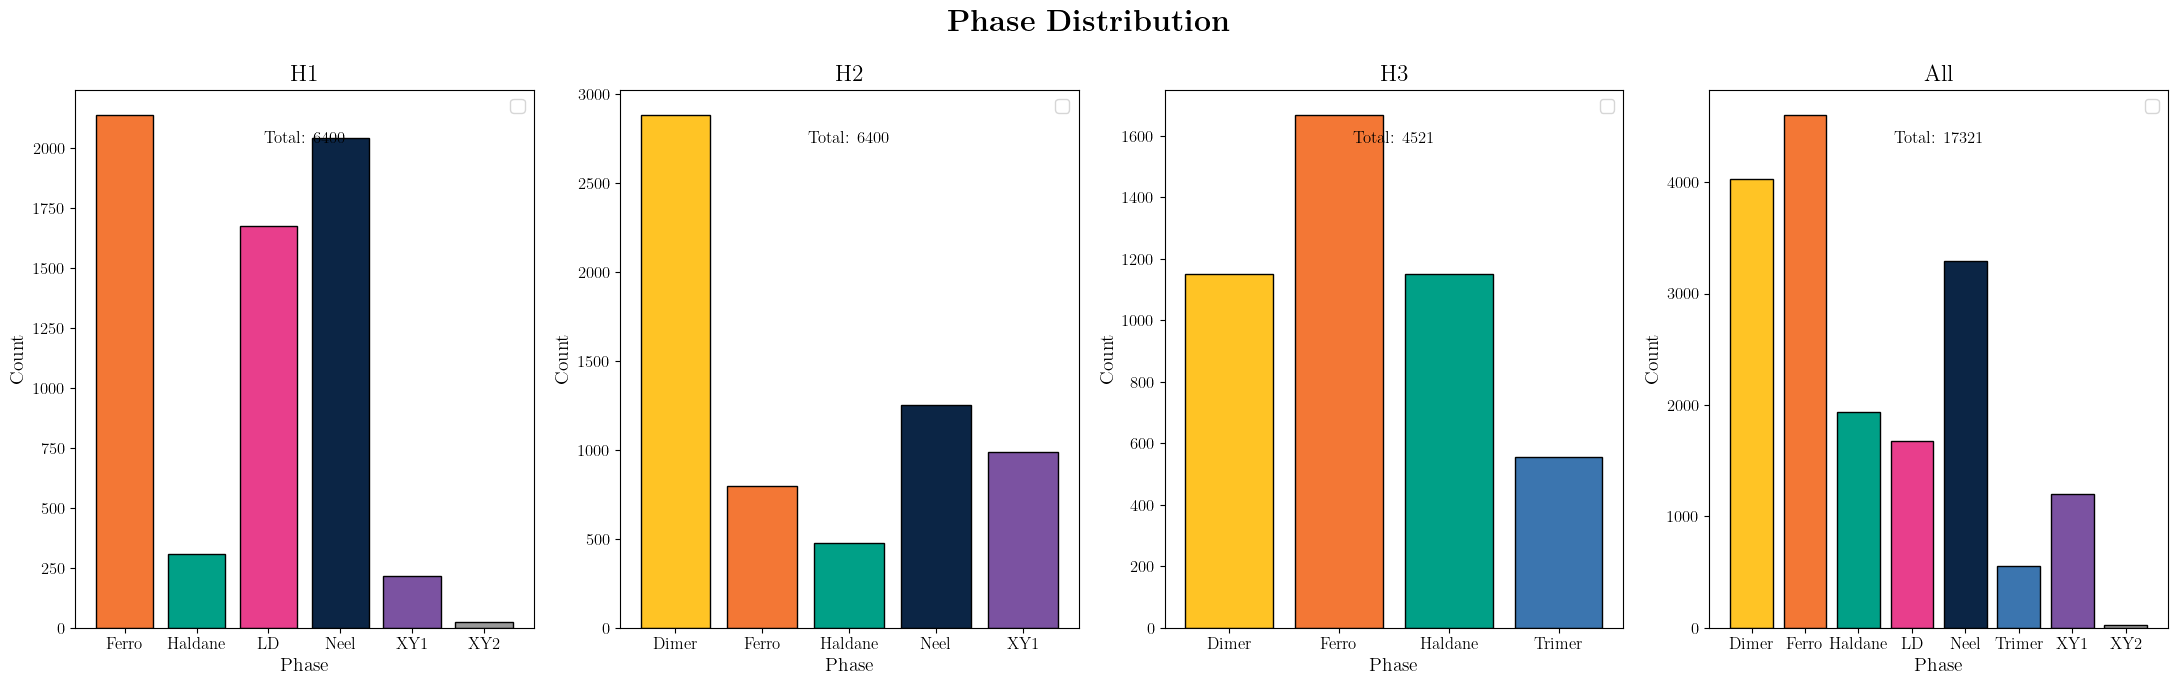

In [8]:
def plot_phase_distribution(corr_dfs: dict[str, pd.DataFrame]):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 4, figsize=(22, 7))
    for i, (key, df) in enumerate(corr_dfs.items()):
        phases, counts = np.unique(df["labels"], return_counts=True)
        colors = [PHASE_COLORS[phase] for phase in phases]
        axs[i].bar(phases, counts, color=colors, edgecolor="black")
        axs[i].set_title(f"{key.capitalize()}")
        axs[i].annotate(
            f"Total: {len(df)}",
            xy=(0.5, 0.9),
            xycoords="axes fraction",
            ha="center",
            fontsize=12,
        )
        axs[i].set_xlabel("Phase")
        axs[i].set_ylabel("Count")
        axs[i].legend()
        fig.suptitle(r"$\textbf{Phase Distribution}$")
        fig.tight_layout()
    fig.savefig("images/phase_distribution.png")


with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    plot_phase_distribution(corr_dfs)

<class 'matplotlib.axes._axes.Axes'>


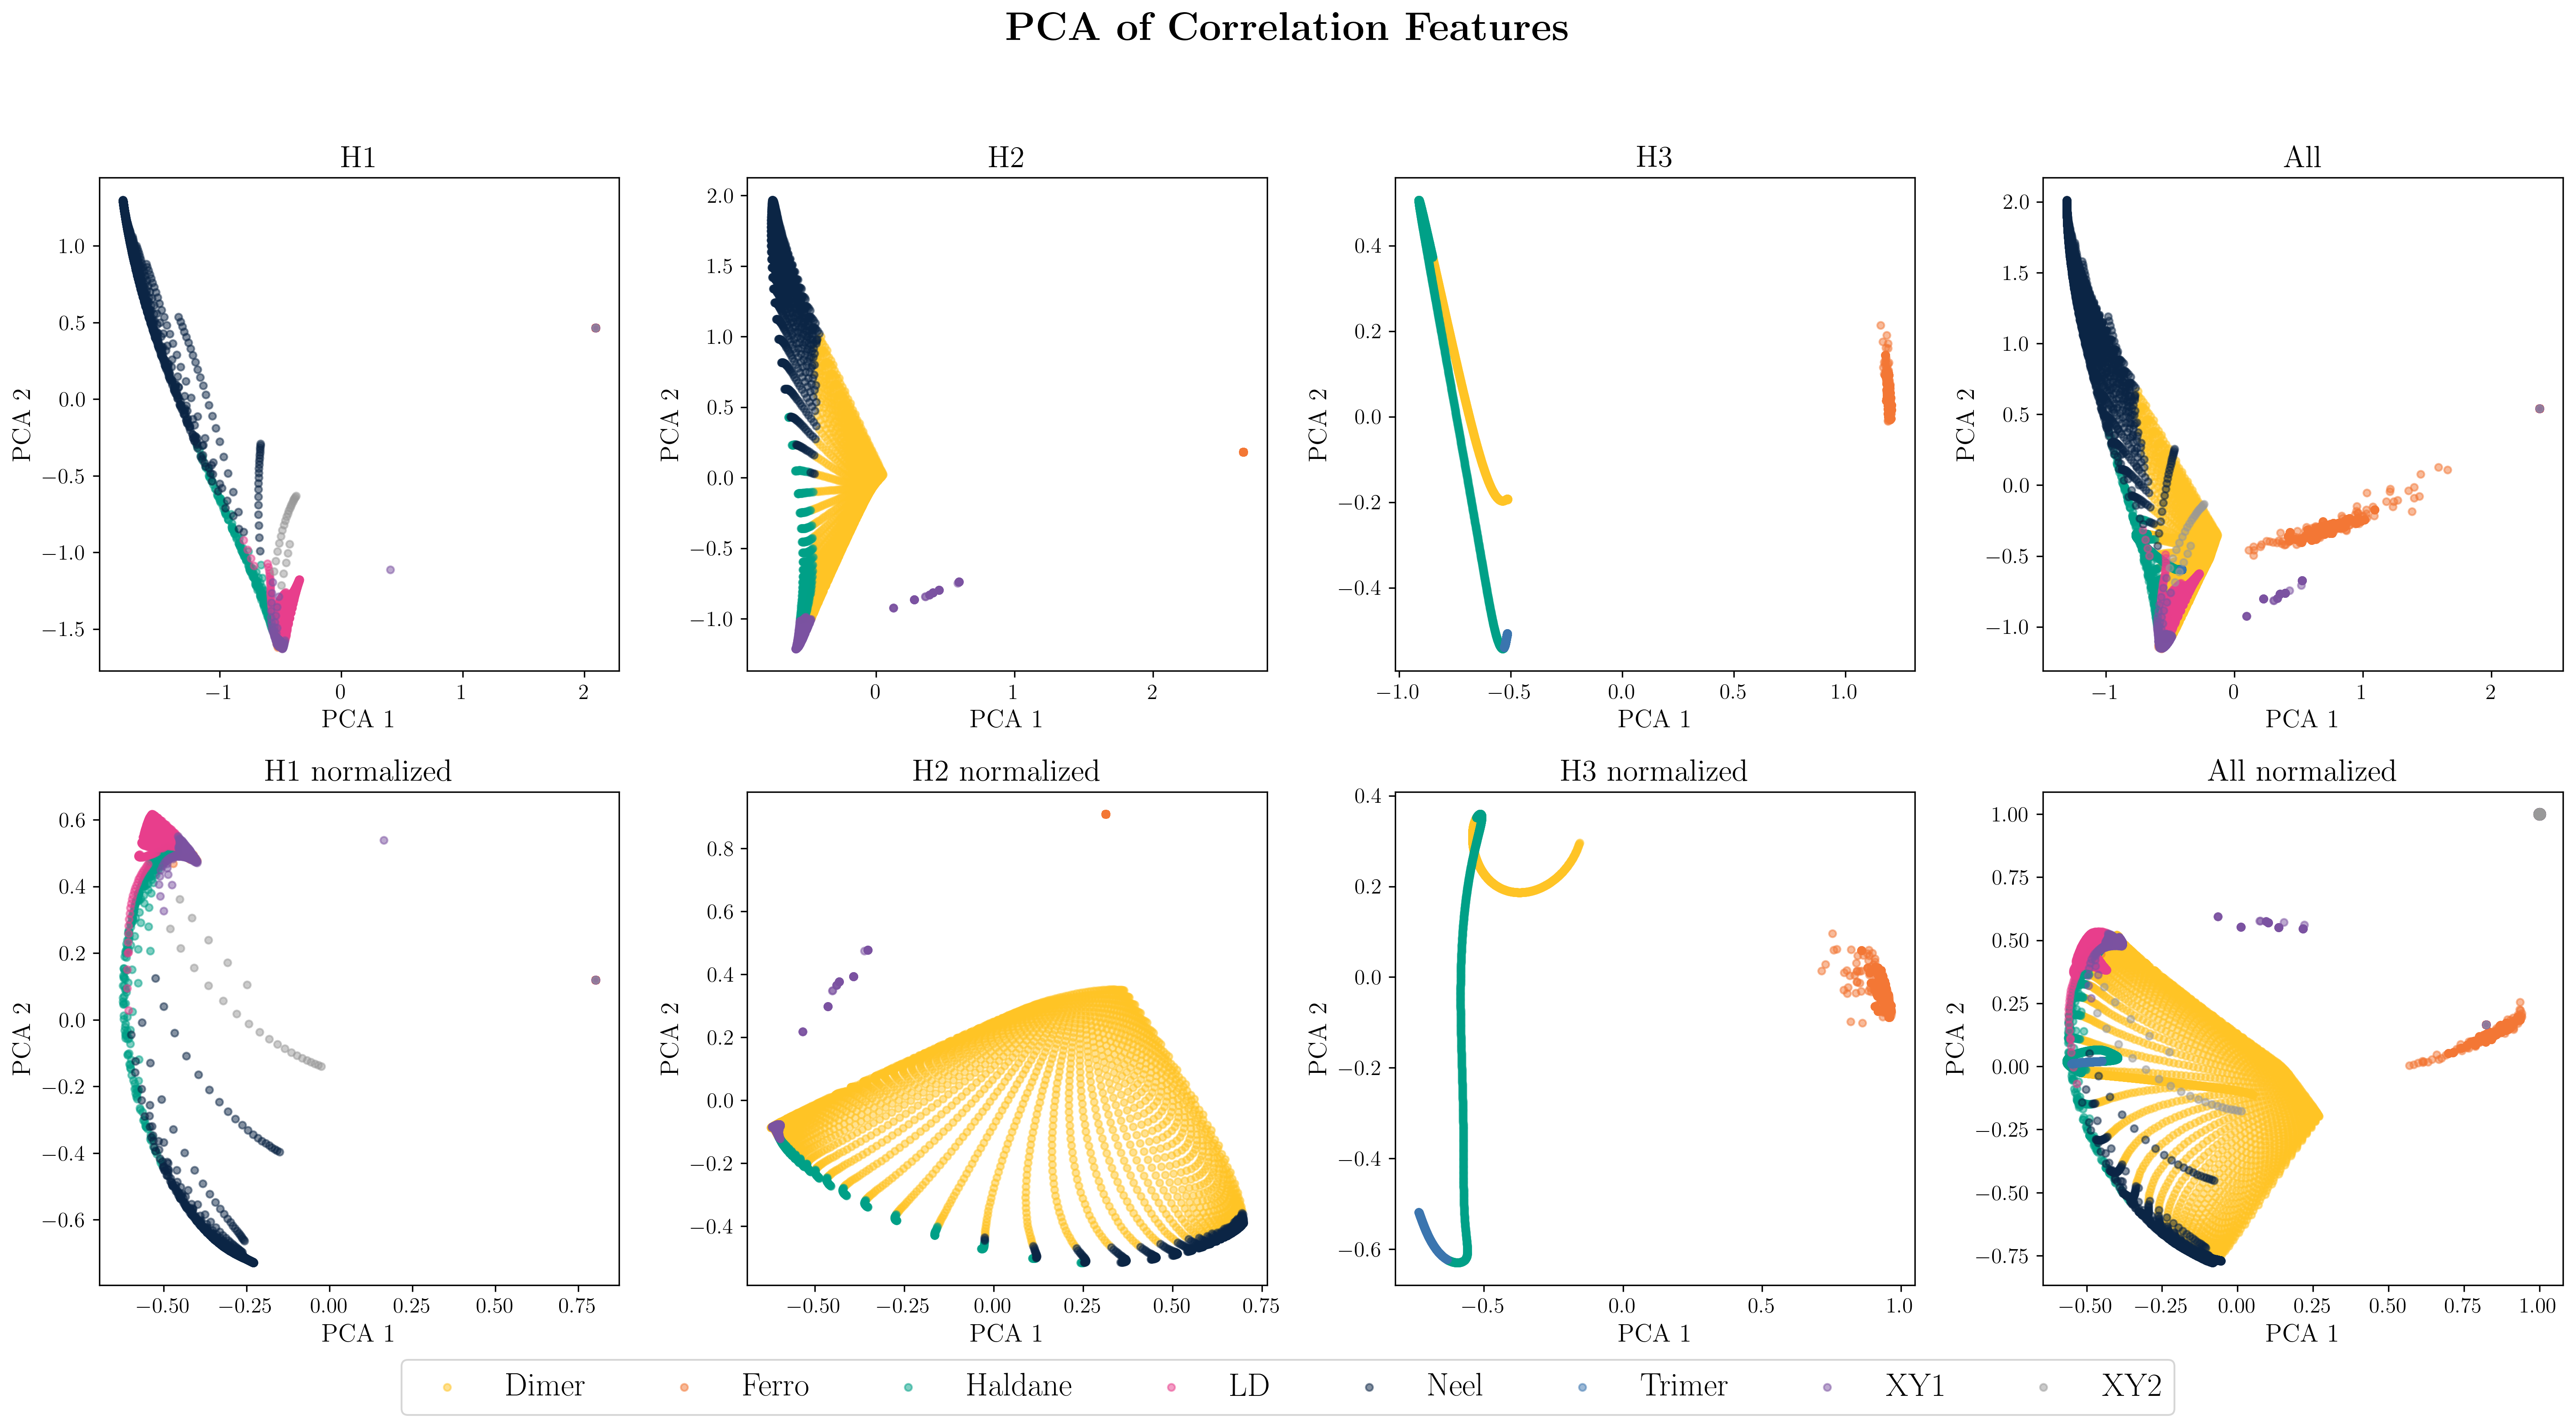

In [9]:
PCA_keys = H_KEYS + tuple(["all"])

_fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 11), dpi=300)
handles, labels = [], []

print(type(_axs[1][0]))


def plot_PCA(
    corr_dfs: dict[str, pd.DataFrame],
    key: str,
    ax: Axes,
    normalize: bool = True,
):
    steps = []  # pipeline steps

    X, y = get_Xy(corr_dfs[key])
    if normalize:
        steps.append(("normalizer", Normalizer()))
    steps.append(("pca", PCA(n_components=2)))
    pipe = Pipeline(steps)

    X = pipe.fit_transform(X)

    norm_str = " normalized" if normalize else ""

    ax.set_title(f"{key.capitalize()}{norm_str}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    classes = np.unique(y)
    for c in classes:
        nodes = np.where(y == c)
        ax.scatter(
            X[nodes, 0],
            X[nodes, 1],
            color=PHASE_COLORS[c],
            label=c,
            alpha=0.5,
            s=15,
        )

    return None


_fig.suptitle(r"$\textbf{PCA of Correlation Features}$", fontweight="bold")


for i in range(8):
    _normalize = i // 4 != 0
    plot_PCA(corr_dfs, PCA_keys[i % 4], _axs.flatten()[i], normalize=(_normalize))

for i in range(len(PHASES)):
    handles.append(plt.scatter([1], [1], c=COLORS[i], label=PHASES[i], marker="o"))

handles, labels = _axs[0, 3].get_legend_handles_labels()
_fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(PHASES),
    fontsize=18,
    bbox_to_anchor=(0.5, -0.01),
)

plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))  # Adjust rect to make space for suptitle


_fig.savefig(f"images/PCA_corr_N{N}.png")
# _fig.savefig(f"images/PCA_corr_N{N}.svg", format="svg")

## Machine Learning

### KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier


def KNN_classify(
    test_key: str,
    ignored_phases: list[str] = [],
    corr_dfs: dict[str, pd.DataFrame] = corr_dfs,
    pred_dfs: dict[str, pd.DataFrame] = pred_dfs,
) -> str | dict:
    train_keys = list(corr_dfs.keys())
    train_keys.remove(test_key)
    train_keys.remove("all")

    # Gets used in the KNN
    X = None
    y = None

    for key in train_keys:
        X_key, y_key = get_Xy(corr_dfs[key])

        if X is None:
            X = X_key
        else:
            X = np.vstack((X, X_key))
        if y is None:
            y = y_key
        else:
            y = np.hstack((y, y_key))

    # Gets X_prev and Y prev
    test_df = corr_dfs[test_key][~corr_dfs[test_key]["labels"].isin(ignored_phases)]
    X_test, y_test = get_Xy(test_df)

    knn = KNeighborsClassifier(50, weights="distance", n_jobs=2)

    pipe = Pipeline(
        (
            ("normalizer", Normalizer()),
            ("knn", knn),
        )
    )

    pipe.fit(X, y)  # type: ignore
    X_pred = get_Xy(corr_dfs[test_key])[0]
    pred_dfs[test_key]["knn"] = pipe.predict(X_pred)

    # This is ugly please adjust it later to make it less redundant
    y_test_pred = pipe.predict(X_test)
    print(f"{test_key} prediction score: {pipe.score(X_test, y_test)}")
    # print(classification_report(y_test, y_test_pred))


KNN_classify("H3", ["Trimer"])
KNN_classify("H2")
KNN_classify("H1", ["LD", "XY1"])

H3 prediction score: 0.8837912780438618
H2 prediction score: 0.73890625
H1 prediction score: 0.9787139689578714


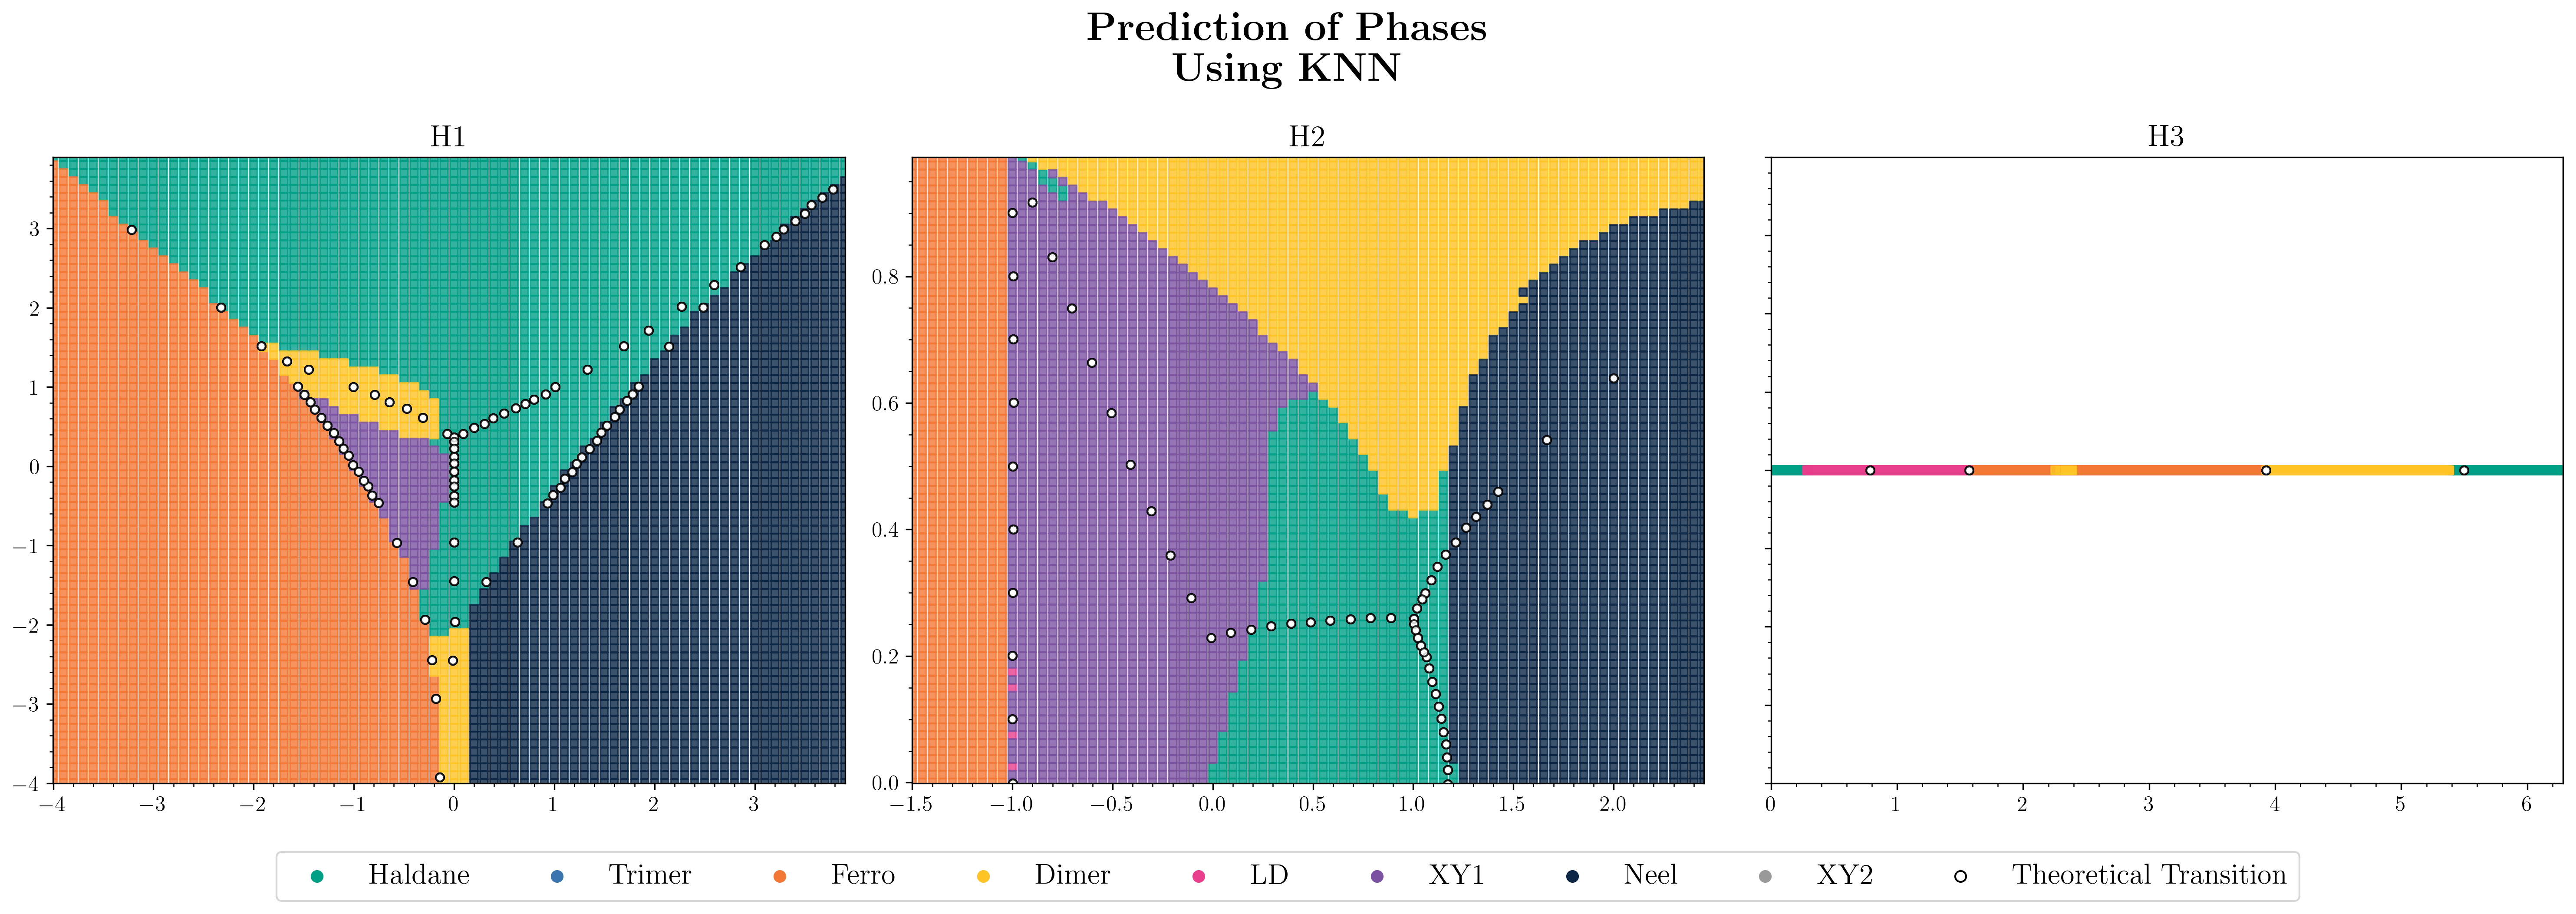

In [102]:
handles, labels = [], []


def plot_graphs(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
    ax.set_title(f"{key}")
    df = pred_dfs[key]
    for phase in PHASES:
        phase_data = df[df["knn"] == phase].values

        ax.scatter(
            phase_data[:, 0],
            phase_data[:, 1],
            marker="s",
            label=phase,
            color=PHASE_COLORS[phase],
            alpha=0.8,
            s=18,
        )
        ax.scatter(
            PHASE_TRANSITIONS[key][:, 0],
            PHASE_TRANSITIONS[key][:, 1],
            marker="o",
            label="Theoretical Transition",
            color="white",
            alpha=0.8,
            s=20,
            edgecolor="black",
        )
    ax.tick_params(
        axis="both",
        which="major",
    )
    ax.minorticks_on()

    # Collect all x and y values for setting axis limits
    all_x, all_y = [], []
    all_x.extend(df.values[:, 0])
    all_y.extend(df.values[:, 1])
    ax.tick_params(
        axis="both",
        which="major",
    )
    # Set tight axis limits
    if len(all_x) > 0 and len(all_y) > 0:
        ax.set_xlim(min(all_x) - 0.001, max(all_x) + 0.001)
        ax.set_ylim(min(all_y) - 0.001, max(all_y) + 0.001)
    if key == "H3":
        ax.set_xlim(0, 2 * np.pi)
        ax.set_ylim(-1.1, -0.9)
        ax.set_yticklabels([])


_fig, _axs = plt.subplots(figsize=(20, 7), ncols=3, nrows=1, dpi=300)
_fig.suptitle(r"""$\textbf{Prediction of Phases}$
              $\textbf{Using KNN}$""")
for i in range(len(PHASES)):
    handles.append(plt.scatter([1], [1], c=COLORS[i], label=PHASES[i], marker="o"))
handles.append(plt.scatter([1], [1], c="white", edgecolor="black", marker="o"))

_fig.legend(
    handles,
    list(PHASES) + ["Theoretical Transition"],
    loc="lower center",
    ncol=len(PHASES)+1,
    fontsize=16,
    bbox_to_anchor=(0.5, -0.01),
)

for i in range(3):
    plot_graphs(pred_dfs, H_KEYS[i], _axs.flatten()[i])

plt.tight_layout(rect=(0.0, 0.07, 1.0, 1))  # Adjust rect to make space for suptitle

_fig.savefig(f"images/knn_prediction_N{N}.png")

### Random Forest

In [65]:
def RF_classify(
    test_key: str,
    ignored_phases: list[str] = [],
    corr_dfs: dict[str, pd.DataFrame] = corr_dfs,
    pred_dfs: dict[str, pd.DataFrame] = pred_dfs,
):
    train_keys = list(corr_dfs.keys())
    train_keys.remove(test_key)
    train_keys.remove("all")

    # Gets used in the KNN
    X = None
    y = None

    for key in train_keys:
        X_key, y_key = get_Xy(corr_dfs[key])

        if X is None:
            X = X_key
        else:
            X = np.vstack((X, X_key))
        if y is None:
            y = y_key
        else:
            y = np.hstack((y, y_key))

    # Gets X_prev and Y prev
    test_df = corr_dfs[test_key][~corr_dfs[test_key]["labels"].isin(ignored_phases)]
    X_test, y_test = get_Xy(test_df)

    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=5012,
        min_samples_split=100,
        max_features="sqrt",
        class_weight="balanced",
    )

    pipe = Pipeline(
        (
            ("normalizer", Normalizer()),
            ("rf", rf),
        )
    )

    pipe.fit(X, y) # type: ignore

    X_pred = get_Xy(corr_dfs[test_key])[0]
    pred_dfs[test_key]["rf_confidence"] = np.amax(pipe.predict_proba(X_pred), axis = 1)
    pred_dfs[test_key]["rf"] = pipe.predict(X_pred)
    print(f"{test_key} prediction score: {pipe.fit(X, y).score(X_test, y_test)}")  # type: ignore


RF_classify("H3", ["Trimer"])
RF_classify("H2")
RF_classify("H1", ["LD", "XY1"])

H3 prediction score: 0.7716158306024704
H2 prediction score: 0.78078125
H1 prediction score: 0.9753880266075388


In [24]:
pred_dfs["H3"].head()

0    1      knn  rf_confidence       rf
0  0.000000 -1.0  Haldane       0.967587  Haldane
1  0.001366 -1.0  Haldane       0.960847  Haldane
2  0.002731 -1.0  Haldane       0.960847  Haldane
3  0.004097 -1.0  Haldane       0.952458  Haldane
4  0.005463 -1.0  Haldane       0.915637  Haldane

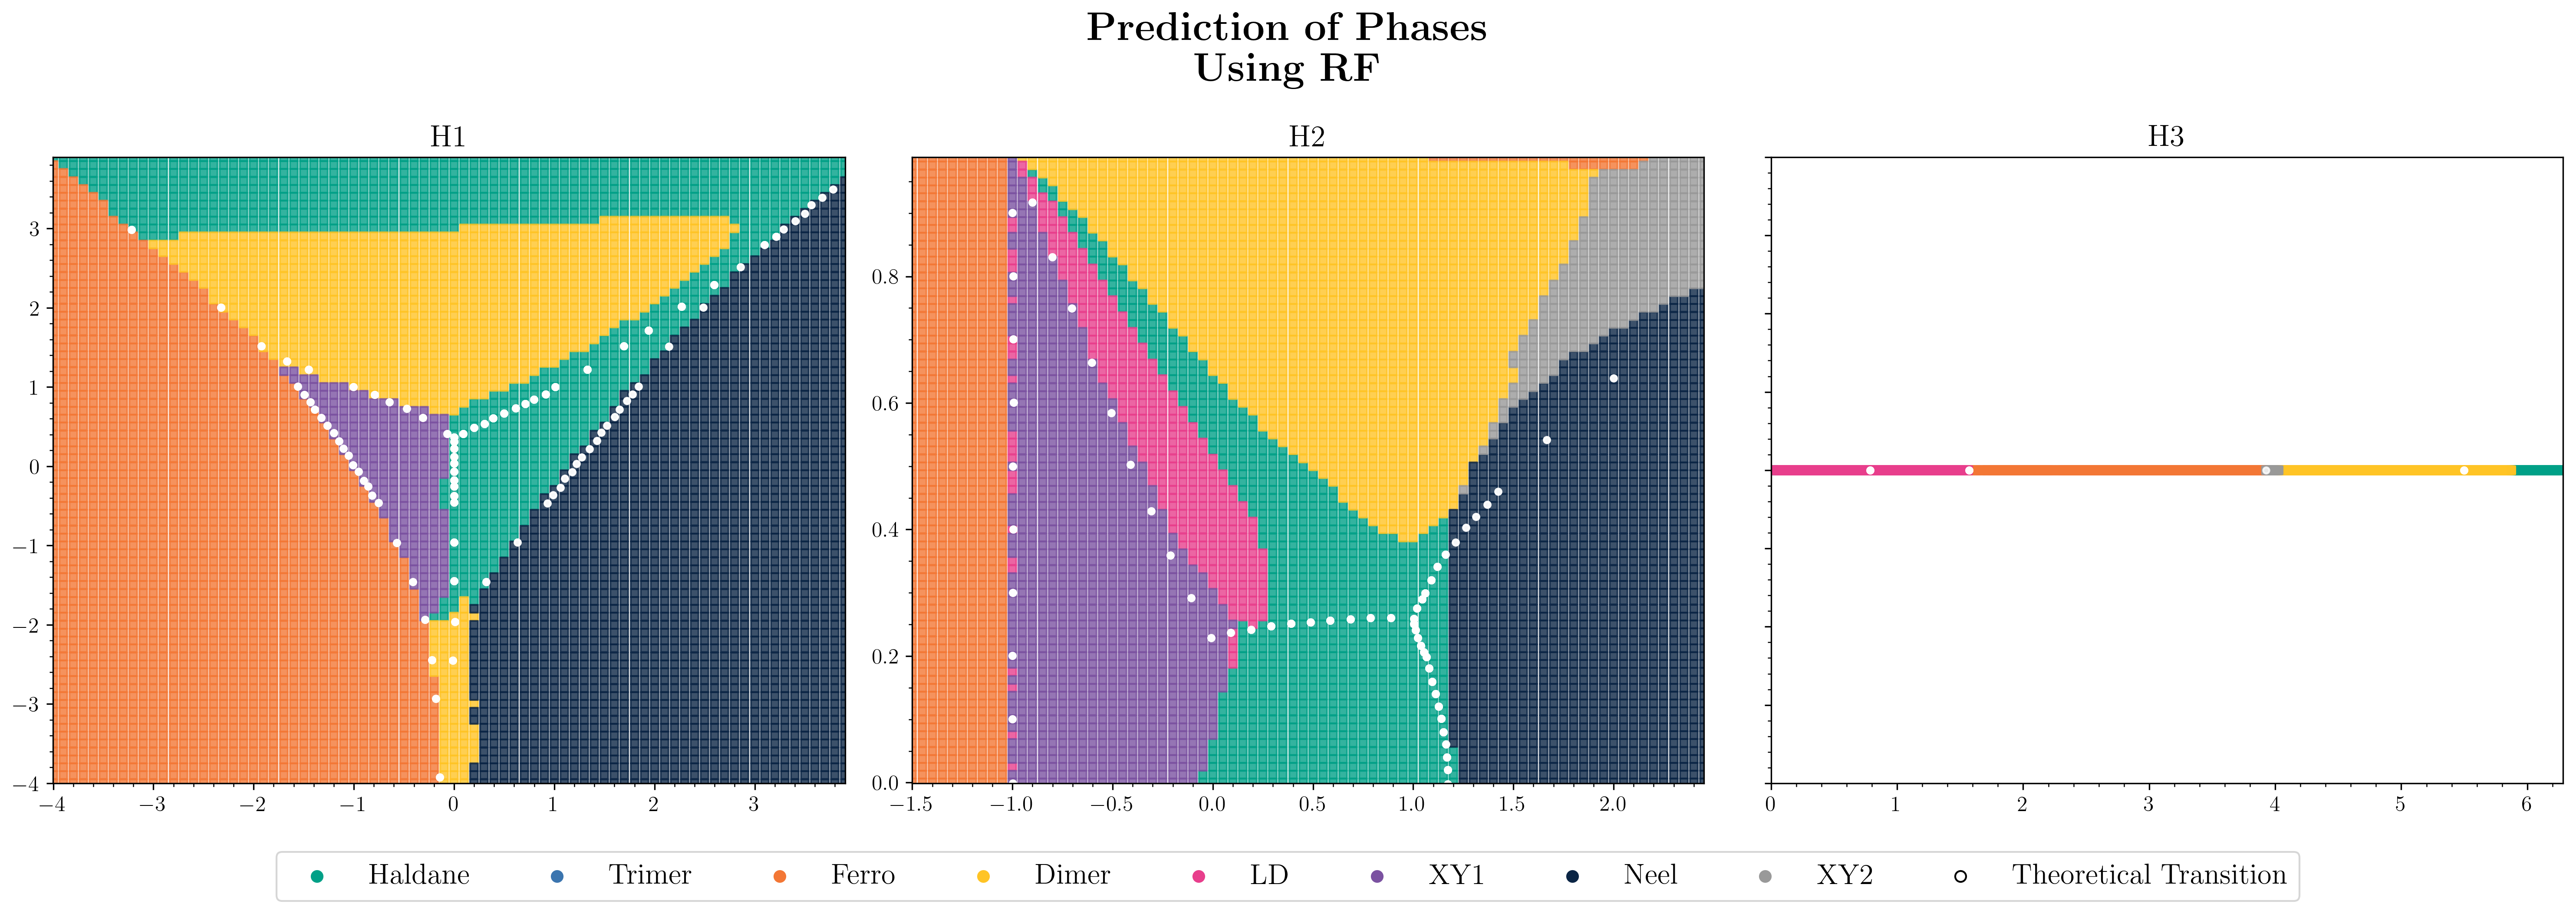

In [104]:
handles, labels = [], []


def plot_graphs_rf(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
    ax.set_title(f"{key}")
    df = pred_dfs[key]
    for phase in PHASES:
        phase_data = df[df["rf"] == phase].values
        ax.scatter(
            phase_data[:, 0],
            phase_data[:, 1],
            marker="s",
            label=phase,
            color=PHASE_COLORS[phase],
            alpha=0.8,
            s=18,
        )
        ax.scatter(
            PHASE_TRANSITIONS[key][:, 0],
            PHASE_TRANSITIONS[key][:, 1],
            marker="o",
            label="Theoretical",
            color="white",
            alpha=0.8,
            s=12,
        )
    ax.tick_params(
        axis="both",
        which="major",
    )
    ax.minorticks_on()

    # Collect all x and y values for setting axis limits
    all_x, all_y = [], []
    all_x.extend(df.values[:, 0])
    all_y.extend(df.values[:, 1])
    ax.tick_params(
        axis="both",
        which="major",
    )
    # Set tight axis limits
    if len(all_x) > 0 and len(all_y) > 0:
        ax.set_xlim(min(all_x) - 0.001, max(all_x) + 0.001)
        ax.set_ylim(min(all_y) - 0.001, max(all_y) + 0.001)
    if key == "H3":
        ax.set_xlim(0, 2 * np.pi)
        ax.set_ylim(-1.1, -0.9)
        ax.set_yticklabels([])


_fig, _axs = plt.subplots(figsize=(20, 7), ncols=3, nrows=1, dpi=300)
_fig.suptitle(r"""$\textbf{Prediction of Phases}$
              $\textbf{Using RF}$""")
for i in range(len(PHASES)):
    handles.append(plt.scatter([1], [1], c=COLORS[i], label=PHASES[i], marker="o"))
handles.append(plt.scatter([1], [1], c="white", edgecolor="black", marker="o"))

_fig.legend(
    handles,
    list(PHASES) + ["Theoretical Transition"],
    loc="lower center",
    ncol=len(PHASES)+1,
    fontsize=16,
    bbox_to_anchor=(0.5, -0.01),
)

for i in range(3):
    plot_graphs_rf(pred_dfs, H_KEYS[i], _axs.flatten()[i])

plt.tight_layout(rect=(0.0, 0.07, 1.0, 1))  # Adjust rect to make space for suptitle

_fig.savefig(f"images/rf_prediction_N{N}.png")

In [25]:
df = pred_dfs["H1"]
x, y = np.unique(df.values[:,0]), np.unique(df.values[:,1])
x, y = x.astype(float), y.astype(float)
X, Y = np.meshgrid(x,y)
conf = df["rf_confidence"].astype(float).values
conf_2d = conf.reshape(len(x), len(y))
np.unique(conf)

array([0.34804548, 0.36039571, 0.37164562, ..., 0.99994981, 0.99997877,
       1.        ])

/tmp/ipykernel_72230/1411023211.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(np.min(y), np.max(y))


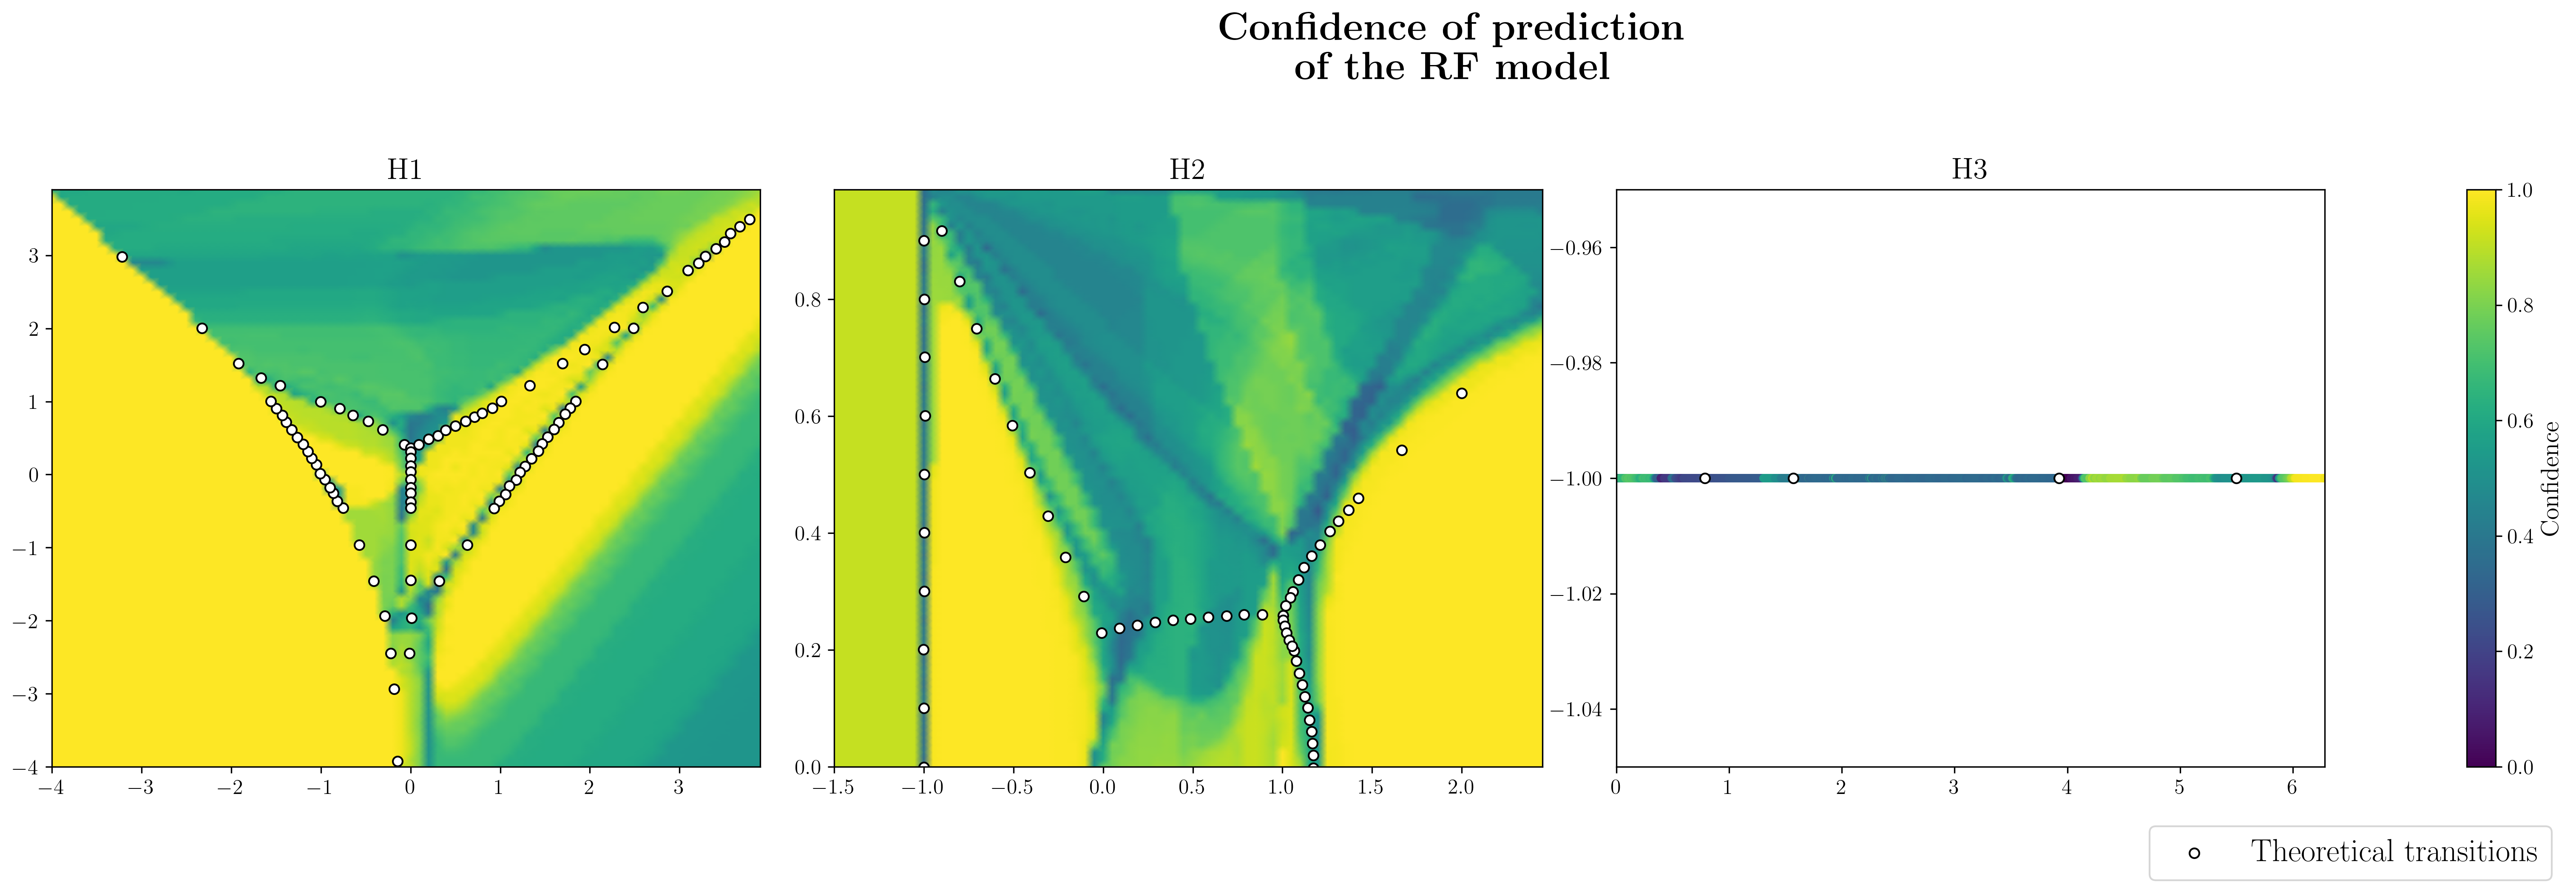

In [129]:
handles, labels = [], []

# def plot_graphs_rf_confidence(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
#     ax.set_title(f"{key}")
#     df = pred_dfs[key]
#     x, y = np.unique(df.values[:,0]), np.unique(df.values[:,1])
#     x, y = x.astype(float), y.astype(float)
#     conf = df["rf_confidence"].astype(float).values
#     conf_2d = conf.reshape(len(x), len(y))
#     X, Y = np.meshgrid(x,y)
#     ax.pcolormesh(
#         X,Y,conf_2d.T, shading='auto', vmin=0, vmax=1
#     )

_fig, _axs = plt.subplots(figsize=(23, 7), ncols=3, nrows=1, dpi=300)
_fig.suptitle(r"""$\textbf{Confidence of prediction}$
              $\textbf{of the RF model}$""")

# Store the mappable returned by pcolormesh for colorbar
mappables = []
for i in range(3):
    ax = _axs.flatten()[i]
    key = H_KEYS[i]
    df = pred_dfs[key]
    label = ""
    if i == 2:
        label = "Theoretical transitions"
        x, y = df.values[:,0], df.values[:,1]
        x, y = x.astype(float), y.astype(float)
        conf = df["rf_confidence"].astype(float).values
        ax.scatter(
            x,
            y,
            c = conf,
            cmap = "viridis",
            alpha=0.8,
            s=14,
        )
    else:
        x, y = np.unique(df.values[:,0]), np.unique(df.values[:,1])
        x, y = x.astype(float), y.astype(float)
        conf = df["rf_confidence"].astype(float).values
        conf_2d = conf.reshape(len(x), len(y))
        X, Y = np.meshgrid(x, y)
        mappable = ax.pcolormesh(X, Y, conf_2d.T, shading='gouraud', cmap="viridis", vmin=0, vmax=1)
        mappables.append(mappable)
    ax.scatter(
            PHASE_TRANSITIONS[key][:, 0],
            PHASE_TRANSITIONS[key][:, 1],
            marker="o",
            edgecolor="black",
            label=label,
            color="white",
            alpha=1,
            s=30,
        )
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))

    ax.set_title(f"{H_KEYS[i]}")



plt.tight_layout(rect=(0.0, 0.07, 1.0, 0.96))  # Adjust rect to make space for suptitle

# Add colorbar using the first mappable
_fig.colorbar(mappables[0], ax=_axs, label='Confidence')
_fig.legend(
    loc="lower right",
    fontsize=18,
    bbox_to_anchor=(0.88, -0.01),
)
_fig.savefig(f"images/rf_confidence_N{N}.png")

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression


def logistical_classify(
    corr_dfs: dict[str, pd.DataFrame],
    test_key: str,
    ignored_phases: list[str] = [],
):
    train_keys = list(corr_dfs.keys())
    train_keys.remove(test_key)
    train_keys.remove("all")

    # Gets used in the KNN
    X = None
    y = None

    for key in train_keys:
        X_key, y_key = get_Xy(corr_dfs[key])

        if X is None:
            X = X_key
        else:
            X = np.vstack((X, X_key))
        if y is None:
            y = y_key
        else:
            y = np.hstack((y, y_key))

    # Gets X_prev and Y prev
    test_df = corr_dfs[test_key][~corr_dfs[test_key]["labels"].isin(ignored_phases)]
    X_test, y_test = get_Xy(test_df)

    clf = LogisticRegression()

    pipe = Pipeline(
        (
            ("normalizer", Normalizer()),
            ("clf", clf),
        )
    )

    # pipe.fit(X, y) # type: ignore

    # X_pred = get_Xy(corr_dfs[test_key])[0]
    # corr_dfs[test_key]["knn"] = pipe.predict(X_pred)
    print(f"{test_key} prediction score: {pipe.fit(X, y).score(X_test, y_test)}")  # type: ignore


logistical_classify(corr_dfs, "H3", ["Trimer"])
logistical_classify(corr_dfs, "H2")
logistical_classify(corr_dfs, "H1", ["LD", "XY1"])

H3 prediction score: 0.5336526342324175
H2 prediction score: 0.7496875
H1 prediction score: 0.9751662971175167


### Deep Learning

In [18]:
# import Keras
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense, Dropout